# The Battle of the Neighbourhoods - *Coursera Capstone*

### Sam Hyland

## Introduction

We are attempting to find the best location for a pop-up Coffee vending machine making high quality coffee. Our location has been narrowed down to the following criteria:

*We will be targetting the capital cities of the 4 Scandinavian countries as they have been identified as the top coffee drinkers in the world.*

*We will be positioning the machine nearby to one of the local univesities given the consumption habits of university students around coffee and having greater budgetary sensitivity.*

*There is a greatly reduced presence of large coffee chains in these cities but we will still seek to avoid proximity to cafés as much as possible.*

We will be running an analysis using Foursquare location and venue data along with a clustering algorithm to ultimately find the optimum location.

# Data

our decision will be based off of the following data:

* Venue locations from Foursquare
* Universities locations within cities as provided by PositionStack
* University names as provided by Unipage

The data sources can be seen below:

* Foursquare API for venue details
* Unipage webpages for university listings
* Positionstack API to get university aproximate coordinates where available (due Google Maps API pricing)


In [1]:
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import requests
from bs4 import BeautifulSoup


The 4 capital cities' coordinates can be entered in manually here sourced via Google maps to get an approximate "centre" of the city

In [2]:
city_data = [['Copenhagen', 55.6712474, 12.5237845], ['Oslo', 59.9048471, 10.7543535], ['Stockholm', 59.3260668, 17.8419713], ['Helsinki', 60.1098678, 24.7385082]]

cities = pd.DataFrame(city_data,columns = ['City', 'Lat', 'Lon'])
cities

,City,Lat,Lon
0,Copenhagen,55.671247,12.523784
1,Oslo,59.904847,10.754354
2,Stockholm,59.326067,17.841971
3,Helsinki,60.109868,24.738508


In [3]:
for i in cities['City']:
    print('city of {}'.format(i))

city of Copenhagen
city of Oslo
city of Stockholm
city of Helsinki


Below we will create a table of universities per city by accessing a webpage listing all the universites for each city and their respective prices of enrollment (credit Unipage).

In [4]:
col_city = []
col_uni = []
pd.set_option('mode.chained_assignment',None)

for city in cities['City']:

    url_text = requests.get('https://www.unipage.net/en/universities/{}'.format(city)).text
    soup = BeautifulSoup(url_text, 'html5lib')

    tabl = soup.find(attrs={"ict-source":"/en/universities"})

    for uni in tabl.find_all('a'):
        col_city.append(city)
        col_uni.append(uni.contents[0])
        
df = pd.DataFrame({'City':col_city, 'University': col_uni})


df_use = df[(df['University'] != 'Bachelor') & (df['University'] != 'Master')]

country_conditions = [df_use['City'].eq('Copenhagen'),
                      df_use['City'].eq('Stockholm'),
                      df_use['City'].eq('Oslo'),
                      df_use['City'].eq('Helsinki')
                     ]

country_values = ['Denmark', 'Sweden', 'Norway', 'Finland']

df_use['Country'] = np.select(country_conditions, country_values, default=0)

df_use = df_use[['Country', 'City', 'University']]

df_use.reset_index(inplace=True)
df_use.drop(['index'], axis=1, inplace=True)
print(df_use.shape)
df_use.head(10)


(55, 3)


,Country,City,University
0,Denmark,Copenhagen,University of Copenhagen
1,Denmark,Copenhagen,Technical University of Denmark
2,Denmark,Copenhagen,Copenhagen Business School
3,Denmark,Copenhagen,IT University of Copenhagen
4,Denmark,Copenhagen,Niels Brock Copenhagen Business College
5,Denmark,Copenhagen,KEA - Copenhagen School Of Design and Technology
6,Denmark,Copenhagen,Kunstakademiets Arkitektskole
7,Denmark,Copenhagen,Zealand Institute Business and Technology
8,Denmark,Copenhagen,Metropolitan University College
9,Denmark,Copenhagen,CPH Business Copenhagen Business Academy


,City,University
0,Copenhagen,13
1,Helsinki,8
2,Oslo,14
3,Stockholm,20


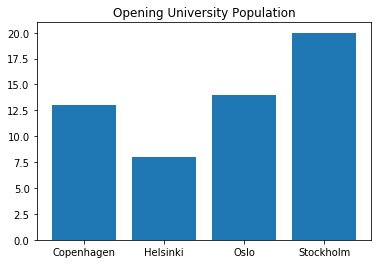

In [5]:
import matplotlib.pyplot as plt

plt_1 = pd.DataFrame(df_use.groupby(by='City').agg('count')['University'])

plt_1 = plt_1.reset_index()

x = plt_1['City']
y = plt_1['University']

plt.bar(x,y)
plt.title('Opening University Population')
plt.show
plt_1


Next we will feed the university names into the PositionStack API to see if we can determine a set of geographic coordinates for them. Any university that we cannot find a match to will be removed as it cannot be used as a base around which to search for Cafés.

In [6]:
import http.client, urllib.parse
import json
temp_key = '#' # deleted for privacy
conn = http.client.HTTPConnection('api.positionstack.com')
counter = 0

final_uni = pd.DataFrame(columns=(['country','City', 'University location', 'latitude', 'longitude']))

for index, row in df_use.iterrows():

    params = urllib.parse.urlencode({
        'access_key': temp_key,
        'query': row['University'],
        'region': row['City'],
        'limit': 1,
        })

    conn.request('GET', '/v1/forward?{}'.format(params))

    res = conn.getresponse()
    data = res.read()
    data_json = json.loads(data.decode('utf-8'))
    
    if len(data_json["data"]) != 0:
        con = df_use['Country'][counter]
        cit = df_use['City'][counter]
        UL = df_use['University'][counter]
        UL_lat = data_json["data"][0]['latitude']
        UL_lon = data_json["data"][0]['longitude']
        temp_df = pd.DataFrame([[con, cit, UL, UL_lat, UL_lon]], columns=(['country','City', 'University location', 'latitude', 'longitude']))
        final_uni = final_uni.append(temp_df)
    else:
        con = df_use['Country'][counter]
        cit = df_use['City'][counter]
        UL = df_use['University'][counter]
        UL_lat = np.nan
        UL_lon = np.nan
        temp_df = pd.DataFrame([[con, cit, UL, UL_lat, UL_lon]], columns=(['country','City', 'University location', 'latitude', 'longitude']))
        final_uni = final_uni.append(temp_df)
    
    counter = counter + 1
    
final_uni.reset_index(inplace=True)

final_uni.drop(['index'], axis=1, inplace=True)

final_uni
    
        

,country,City,University location,latitude,longitude
0,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290
1,Denmark,Copenhagen,Technical University of Denmark,55.785550,12.518920
2,Denmark,Copenhagen,Copenhagen Business School,55.704438,12.502119
3,Denmark,Copenhagen,IT University of Copenhagen,55.696950,12.571311
4,Denmark,Copenhagen,Niels Brock Copenhagen Business College,55.681004,12.554313
5,Denmark,Copenhagen,KEA - Copenhagen School Of Design and Technology,56.037665,12.614415
6,Denmark,Copenhagen,Kunstakademiets Arkitektskole,55.683198,12.604454
7,Denmark,Copenhagen,Zealand Institute Business and Technology,NaN,NaN
8,Denmark,Copenhagen,Metropolitan University College,NaN,NaN
9,Denmark,Copenhagen,CPH Business Copenhagen Business Academy,55.770080,12.512304


In [7]:
final_uni_use = final_uni.dropna()
final_uni_use

,country,City,University location,latitude,longitude
0,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290
1,Denmark,Copenhagen,Technical University of Denmark,55.785550,12.518920
2,Denmark,Copenhagen,Copenhagen Business School,55.704438,12.502119
3,Denmark,Copenhagen,IT University of Copenhagen,55.696950,12.571311
4,Denmark,Copenhagen,Niels Brock Copenhagen Business College,55.681004,12.554313
5,Denmark,Copenhagen,KEA - Copenhagen School Of Design and Technology,56.037665,12.614415
6,Denmark,Copenhagen,Kunstakademiets Arkitektskole,55.683198,12.604454
9,Denmark,Copenhagen,CPH Business Copenhagen Business Academy,55.770080,12.512304
10,Denmark,Copenhagen,Copenhagen West Business College,55.681004,12.554313
12,Denmark,Copenhagen,Copenhagen Polytechnic,55.704438,12.502119


,City,Universities
0,Copenhagen,10
1,Helsinki,5
2,Oslo,5
3,Stockholm,9


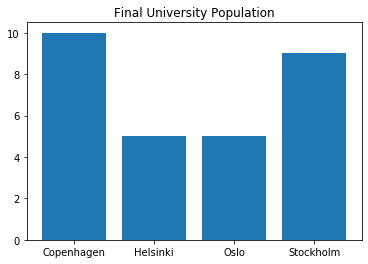

In [8]:
plt_2 = pd.DataFrame(final_uni_use.groupby(by='City').agg('count')['University location'])

plt_2 = plt_2.reset_index()

plt_2.rename(columns={'University location': 'Universities'}, inplace=True)

x = plt_2['City']
y = plt_2['Universities']

plt.bar(x,y)
plt.title('Final University Population')
plt.show
plt_2

With the university locations finalised we will be getting the first 10 cafés as per the café venue category from FourSquare within a 2km radius for each university site. Some non cafés in the venue category will be removed from the dataset.

Ids have been deleted for privacy

In [9]:
CLIENT_ID = '#' # your Foursquare ID
CLIENT_SECRET = '#' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 10 # deleted details for privacy

In [10]:
cafe_foursquare_id = '4bf58dd8d48988d16d941735' # category id for all colleges and universities

In [11]:
radius = 2000 # defined radius of 2km
query = 'Cafe'

df_cafes = []

for country, city, name, lat, lng in zip(final_uni_use['country'], final_uni_use['City'],final_uni_use['University location'],final_uni_use['latitude'], final_uni_use['longitude']):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius,
        query,
        LIMIT,
        cafe_foursquare_id)


    sq_results = requests.get(url).json()["response"]['groups'][0]['items']
    
    df_cafes.append([(
            country,
            city,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in sq_results])

    df_full_cafes = pd.DataFrame([item for cafe_list in df_cafes for item in cafe_list])
    df_full_cafes.columns = ['Country',
                        'City',
                        'University', 
                        'Uni Latitude', 
                        'Uni Longitude', 
                        'Venue', 
                        'Venue Latitude', 
                        'Venue Longitude', 
                        'Venue Category']
    
print(df_full_cafes.shape)
df_full_cafes.head(50)

(248, 9)


,Country,City,University,Uni Latitude,Uni Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,Paludan Bogcafé,55.680419,12.573238,Café
1,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,The Coffee Collective,55.683695,12.569790,Café
2,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,The Living Room,55.678535,12.569162,Café
3,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,Kalaset,55.684608,12.566576,Café
4,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,Hacienda Café,55.682397,12.566356,Café
5,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,Arket,55.680555,12.578148,Clothing Store
6,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,Bevars,55.688455,12.561880,Café
7,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,Københavns Hovedbibliotek,55.680743,12.573736,Library
8,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,Arabica,55.687046,12.558931,Café
9,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,Auto,55.688321,12.554460,Café


In [12]:
final_cafes = df_full_cafes
final_cafes = final_cafes.loc[(final_cafes['Venue Category'] == 'Café') | (final_cafes['Venue Category'] == 'Coffee Shop')]

final_cafes['Venue Category'].value_counts()

Café           237
Coffee Shop      5
Name: Venue Category, dtype: int64

Geopy is now installed to get the distance between the university and the respective café which will be used to inform the clustering and our decision.

In [13]:
! pip install geopy

In [14]:
from geopy import distance

cafes_listing = []

for country, city, uni, cafe, uni_lat, uni_lon, v_lat, v_lon in zip(final_cafes['Country'], final_cafes['City'],final_cafes['University'], final_cafes['Venue'], final_cafes['Uni Latitude'], final_cafes['Uni Longitude'], final_cafes['Venue Latitude'], final_cafes['Venue Longitude']):
    x = (uni_lat, uni_lon)
    y = (v_lat, v_lon)
    dist = distance.distance(x,y).km
    
    
    cafes_listing.append([(
            country,
            city,
            uni, 
            uni_lat, 
            uni_lon, 
            cafe,
            v_lat,
            v_lon,
            dist)])

    cafes_for_cluster = pd.DataFrame([item for cafe_list in cafes_listing for item in cafe_list])
    cafes_for_cluster.columns = ['Country',
                        'City',
                        'University', 
                        'Uni Latitude', 
                        'Uni Longitude', 
                        'Café Name', 
                        'Venue Latitude', 
                        'Venue Longitude', 
                        'Distance_to_uni']
    
cafes_for_cluster.head(10)

,Country,City,University,Uni Latitude,Uni Longitude,Café Name,Venue Latitude,Venue Longitude,Distance_to_uni
0,Denmark,Copenhagen,University of Copenhagen,55.68743,12.57329,Paludan Bogcafé,55.680419,12.573238,0.780611
1,Denmark,Copenhagen,University of Copenhagen,55.68743,12.57329,The Coffee Collective,55.683695,12.569790,0.470562
2,Denmark,Copenhagen,University of Copenhagen,55.68743,12.57329,The Living Room,55.678535,12.569162,1.023810
3,Denmark,Copenhagen,University of Copenhagen,55.68743,12.57329,Kalaset,55.684608,12.566576,0.526372
4,Denmark,Copenhagen,University of Copenhagen,55.68743,12.57329,Hacienda Café,55.682397,12.566356,0.710131
5,Denmark,Copenhagen,University of Copenhagen,55.68743,12.57329,Bevars,55.688455,12.561880,0.726652
6,Denmark,Copenhagen,University of Copenhagen,55.68743,12.57329,Arabica,55.687046,12.558931,0.904133
7,Denmark,Copenhagen,University of Copenhagen,55.68743,12.57329,Auto,55.688321,12.554460,1.188424
8,Denmark,Copenhagen,Technical University of Denmark,55.78555,12.51892,Café mig og Annie,55.769773,12.504465,1.976924
9,Denmark,Copenhagen,Technical University of Denmark,55.78555,12.51892,Café Amalie,55.770986,12.502778,1.911899


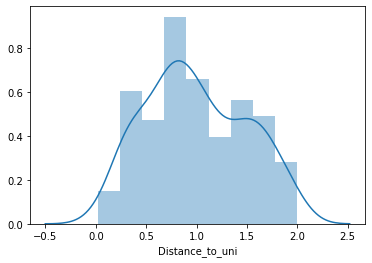

In [15]:
sns.distplot(cafes_for_cluster['Distance_to_uni'])

In [16]:
cafes_for_cluster[cafes_for_cluster['Café Name'].eq('Arabica')]

,Country,City,University,Uni Latitude,Uni Longitude,Café Name,Venue Latitude,Venue Longitude,Distance_to_uni
6,Denmark,Copenhagen,University of Copenhagen,55.687430,12.573290,Arabica,55.687046,12.558931,0.904133
35,Denmark,Copenhagen,IT University of Copenhagen,55.696950,12.571311,Arabica,55.687046,12.558931,1.349808
47,Denmark,Copenhagen,Niels Brock Copenhagen Business College,55.681004,12.554313,Arabica,55.687046,12.558931,0.732753
87,Denmark,Copenhagen,Copenhagen West Business College,55.681004,12.554313,Arabica,55.687046,12.558931,0.732753


A small cluster dataframe as been created below via joining the different means, counts, max/min based on each café and their metadata. This will be normalised and then fed into the Kmeans clustering algorithm.

In [17]:
counts = pd.DataFrame(cafes_for_cluster.groupby(by='Café Name').agg('count')['University']) 
distance = pd.DataFrame(cafes_for_cluster.groupby(by='Café Name').mean()['Distance_to_uni'])
min_d = pd.DataFrame(cafes_for_cluster.groupby(by='Café Name').min()['Distance_to_uni'])
max_d = pd.DataFrame(cafes_for_cluster.groupby(by='Café Name').max()['Distance_to_uni'])

counts.rename(columns = {'University': '<2km Unis'}, inplace=True)
distance.rename(columns = {'Distance_to_uni': 'Mean Distance'}, inplace=True)
min_d.rename(columns = {'Distance_to_uni': 'Lowest Distance'}, inplace=True)
max_d.rename(columns = {'Distance_to_uni': 'Highest Distance'}, inplace=True)

counts = counts.reset_index()
distance = distance.reset_index()
min_d = min_d.reset_index()
max_d = max_d.reset_index()

cluster_df = distance.join(counts.set_index('Café Name'), on='Café Name').join(min_d.set_index('Café Name'), on='Café Name').join(max_d.set_index('Café Name'), on='Café Name')

cluster_df

,Café Name,Mean Distance,<2km Unis,Lowest Distance,Highest Distance
0,20hundra5,0.949380,1,0.949380,0.949380
1,ADD CAFE,0.435423,2,0.361073,0.509773
2,Amica Cafe Elissa,0.366148,2,0.275645,0.456651
3,Arabica,0.929862,4,0.732753,1.349808
4,Auto,1.062027,4,0.814648,1.430389
...,...,...,...,...,...
136,Älvsjö konditori,1.716447,3,1.716447,1.716447
137,Åpent Bakeri,0.850258,3,0.232223,1.254511
138,Åpent Bakeri Adamstuen,1.146106,3,1.035296,1.265913
139,Åpent Bakeri Barcode,1.249683,1,1.249683,1.249683


<function matplotlib.pyplot.show(*args, **kw)>

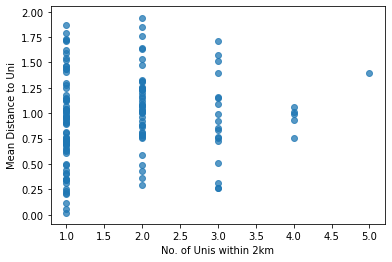

In [23]:
fig, ax = plt.subplots()
ax.scatter(cluster_df['<2km Unis'], cluster_df['Mean Distance'], alpha = .75)
ax.set_xlabel('No. of Unis within 2km')
ax.set_ylabel('Mean Distance to Uni')
plt.show

In [17]:
from sklearn.preprocessing import MinMaxScaler

cluster_df_minmax = cluster_df.drop('Café Name', 1)

cluster_df_minmax = pd.DataFrame(MinMaxScaler().fit_transform(cluster_df_minmax),
                                columns=cluster_df_minmax.columns, index=cluster_df_minmax.index) 

cluster_df_minmax

,Mean Distance,<2km Unis,Lowest Distance,Highest Distance
0,0.469753,0.00,0.469753,0.469753
1,0.209320,0.25,0.171646,0.246995
2,0.174217,0.25,0.128358,0.220077
3,0.984315,0.00,0.984315,0.984315
4,0.459863,0.75,0.359984,0.672659
...,...,...,...,...
138,0.858442,0.50,0.858442,0.858442
139,0.419526,0.50,0.106354,0.624370
140,0.569438,0.50,0.513289,0.630147
141,0.621923,0.00,0.621923,0.621923


The Kmeans clustering algorithm is now run using an input of 4 clusters.

In [18]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_df_minmax)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 3, 2, 2, 0, 1, 1, 1])

In [21]:
# add clustering labels
cluster_df.insert(0, 'Cluster Labels', kmeans.labels_)

final_df = cafes_for_cluster

# merge df_grouped with df_merged to add latitude/longitude for each code
final_df = final_df.join(cluster_df.set_index('Café Name'), on='Café Name')

print(final_df.shape)

(244, 14)


With the cluster labels now attached to the dataset we can create the map showcasing the 4 cities and their universities/cafés via folium and Matplotlib.

In [22]:

import matplotlib.cm as cm
import matplotlib.colors as colors

lat_start = 57.817463
lon_start = 18.8245433

# create map
basic_map = folium.Map(location=[lat_start, lon_start], zoom_start=6)

# add markers to the map with additional callouts
for uni, lat, lon in zip(final_uni_use['University location'], final_uni_use['latitude'], final_uni_use['longitude']):
    label_uni = folium.Popup(str(uni), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=2000,
        color='black',
        popup=label_uni,
        fill=True,
        fill_opacity=0.15).add_to(basic_map)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for country, city, uni, cafe, uni_lat, uni_lon, v_lat, v_lon, dist, cluster in zip(final_df['Country'], final_df['City'],final_df['University'], final_df['Café Name'], final_df['Uni Latitude'], final_df['Uni Longitude'], final_df['Venue Latitude'], final_df['Venue Longitude'], final_df['Distance_to_uni'], final_df['Cluster Labels']):
    label = folium.Popup(str(cafe) + ': ' + str(round(dist, 2)) + ' kms away from ' + str(uni) + ' -----> Cluster: ' + str(cluster), parse_html=True)
    folium.Circle(
        [v_lat, v_lon],
        radius=50,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(basic_map)
    

        
basic_map

Cluster level data is shown below so we can formulate a view as to how to identify each cluster based on their characteristics.

In [23]:
view = final_df.groupby(by='Cluster Labels').agg('count')[['Café Name']].join(final_df.groupby(by='Cluster Labels').mean()[['Mean Distance', '<2km Unis', 'Lowest Distance', 'Highest Distance']], on = 'Cluster Labels')

view.rename(columns={'Café Name' : 'Number of Café Members'}, inplace=True)

view

,Number of Café Members,Mean Distance,<2km Unis,Lowest Distance,Highest Distance
Cluster Labels,,,,,
0,39,0.357292,1.871795,0.348838,0.365746
1,65,0.904139,1.400000,0.885852,0.922426
2,92,1.022107,2.869565,0.605962,1.420544
3,48,1.590452,1.916667,1.574738,1.606166


Using the get Dummies for pandas we can see the breakdown of clustering for each university and from that we can draw conclusions on what could be considered the ideal location for our use case.

We can define optimal locations for our vendor based on the combination of the café data in relation to the spacing of the universities.

We will now examine the universities using the get_dummies on the cluster categories to form a basis view for promising candidates based on the clusters breakdown above.

We wish to avoid university with a larger number of Cluster 0 cafés as they are very close to the university.
Cluster 2 cafés seem to be nearby a number of universities (around 3) so they likely cater to a large customer base of students.
Cluster 3 cafés have the furthest mean distance and represent the best opportunities for our vendor so we will aim for a university that maximises them.

In [39]:
for_dummies = final_df[['University', 'City', 'Cluster Labels']]

dummies = pd.get_dummies(for_dummies, columns=['Cluster Labels'])
dummies = dummies.groupby(by=['University', 'City']).sum()

# Lets sort by placing high numbers of cluster 0 at the bottom and lower at the top while prioritising the number of Cluster Labels_3
dummies = dummies.sort_values(by=['Cluster Labels_0', 'Cluster Labels_3'], ascending=[True, False])
print(dummies.shape)
dummies

(29, 4)


,,Cluster Labels_0,Cluster Labels_1,Cluster Labels_2,Cluster Labels_3
University,City,,,,
BI Norwegian Business School,Oslo,0,1,4,5
Stockholm School of Economics,Stockholm,0,0,1,4
Stockholm School of Theology,Stockholm,0,0,1,4
Stockholm University,Stockholm,0,0,1,4
OsloMet - Oslo Metropolitan University,Oslo,0,2,5,1
Technical University of Denmark,Copenhagen,0,0,9,1
CPH Business Copenhagen Business Academy,Copenhagen,0,1,9,0
Karolinska Institute,Stockholm,0,4,6,0
Kunstakademiets Arkitektskole,Copenhagen,0,9,1,0


# Results

By using a listing of 55 colleges in the 4 capitals of the scandinavian countries, 244 cafés/coffee shops have been found by searching within a 2 km radius of each university location as provided by PositionStack API in combination with FourSquare. Overall the population was eventually reduced to 29 universities with found geographical coordinates through the PositionStack API.

Overall this averages out to around 8 universities per location - quite close to the set limit of the first 10 cafés due to usage restrictions on the API. Stockholm and Copenhagen provided the most universities each with Helsinki and Oslo providing fewer universities albeit in quite close proximity to each other with central hubs of cafés and coffee shops.

Upon splitting the results into clusters via a nearest Kmeans clustering algorithm we found that Oslo had the fewest number of cluster 0 cafés characterised as being a café in very close proximity to a university - matching our desired location.

# Discussion

From the above we can determine that we should avoif Helsinki due to a larger prevalence of very close cafés while our prime candidates would be Stockholm and Oslo.

From the above and in checking the map - I would recommend targetting the BI Norwegian Business School which according to its website caters to nearly 20,000 business students making it one of the largest in Europe. The map also shows that the location is quite central and is nearby to the other universities of Oslo providing a large target base.

Stockholm may also be targetted - in particular Stockholm University but independent cross checking of results found the locations provided for some universities in Stockholm to vary in accuracy which damages the analysis into that region as the cafés may not have been pulled from the correct local area.

# Conclusion

While this report provided a brief insight into good locations to set up an automated vendor of coffee in these cities, further work would need to be done around obtaining a vendor license, currency matters, regulatory incorporation, liability coverage - all of which vary for each region. This report could also be improved upon via subsequent analysis with a greater budget to capture more universities across more cities and capture all local cafés and restaurants that serve coffee. This analysis was provided in tandem with the simplified usage case as characterised by the business problem - omitting other cities and countries and locations from the analysis to match our perceived ideal consumer persona of a budget conscious university student.